In [1]:
import tensorflow as tf
from get_data import get_cifar_10

cifar_10 = get_cifar_10("data/cifar_10/")

Unpickling and reshaping data
Finished unpickling and reshaping data


In [2]:
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def batch_normalize(x, axes, depth):
    mean, variance = tf.nn.moments(x, axes)
    offset = tf.Variable(tf.zeros([depth]))
    scale = tf.Variable(tf.ones([depth]))
    return tf.nn.batch_normalization(x, mean, variance, offset, scale, variance_epsilon=1e-5)

def conv2d(x, W, depth):
    return tf.nn.relu(batch_normalize(tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME'), [0, 1, 2], depth))

def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def fc(x, W, depth, keep_prob):
    return tf.nn.dropout(tf.nn.relu(batch_normalize(tf.matmul(x, W), [0], depth)), keep_prob)

In [3]:
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
keep_prob = tf.placeholder(tf.float32)

W_1 = weight_variable([3, 3, 3, 64])
conv_1 = conv2d(x, W_1, depth=64)

W_2 = weight_variable([3, 3, 64, 64])
conv_2 = conv2d(conv_1, W_2, depth=64)

max_pool_2 = max_pool(conv_2)

W_3 = weight_variable([3, 3, 64, 128])
conv_3 = conv2d(max_pool_2, W_3, depth=128)

W_4 = weight_variable([3, 3, 128, 128])
conv_4 = conv2d(conv_3, W_4, depth=128)

max_pool_4 = max_pool(conv_4)
max_pool_4_flat = tf.reshape(max_pool_4, [-1, 8192])

W_5 = weight_variable([8192, 256])
fc_5 = fc(max_pool_4_flat, W_5, depth=256, keep_prob=keep_prob)

W_6 = weight_variable([256, 10])
b_6 = tf.Variable(tf.zeros([10]))
y = tf.matmul(fc_5, W_6) + b_6

In [4]:
y_true = tf.placeholder(tf.float32, [None, 10])
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_true))

step = tf.train.AdamOptimizer(5e-4).minimize(loss)

In [5]:
sess = tf.Session()

In [6]:
sess.run(tf.global_variables_initializer())

losses = []

for i in range(40001):
    x_batch, y_batch = cifar_10.train.next_batch(32)
    _, current_loss = sess.run([step, loss], {x: x_batch, y_true: y_batch, keep_prob: 0.5})
    losses.append(current_loss)
    if i % 2000 == 0:
        print 'loss at step {}: {}'.format(i, current_loss)

loss at step 0: 2.84541535378
loss at step 2000: 0.871781945229
loss at step 4000: 0.885499477386
loss at step 6000: 0.72946035862
loss at step 8000: 0.413950681686
loss at step 10000: 0.470592498779
loss at step 12000: 0.451174080372
loss at step 14000: 0.496252477169
loss at step 16000: 0.172309651971
loss at step 18000: 0.156595557928
loss at step 20000: 0.25634509325
loss at step 22000: 0.0407599285245
loss at step 24000: 0.0474415272474
loss at step 26000: 0.106540903449
loss at step 28000: 0.0736831352115
loss at step 30000: 0.0605808906257
loss at step 32000: 0.0744682699442
loss at step 34000: 0.0481768585742
loss at step 36000: 0.0877644047141
loss at step 38000: 0.0632245540619
loss at step 40000: 0.0604598000646


In [7]:
percent_correct = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_true, 1)), tf.float32))
print sess.run(percent_correct, feed_dict={x: cifar_10.test.data[:1000], y_true: cifar_10.test.labels[:1000], keep_prob: 1})
print sess.run(percent_correct, feed_dict={x: cifar_10.train.data[:1000], y_true: cifar_10.train.labels[:1000], keep_prob: 1})

0.806
0.999


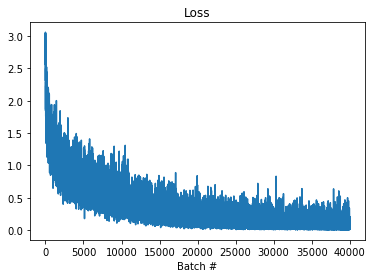

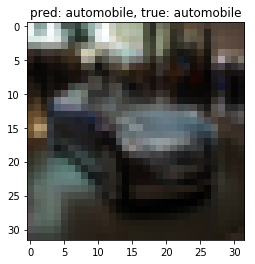

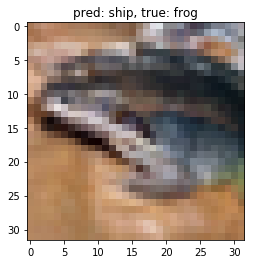

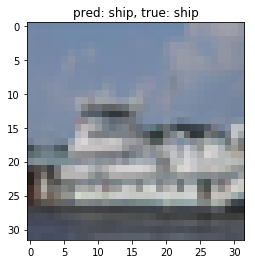

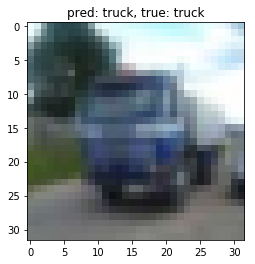

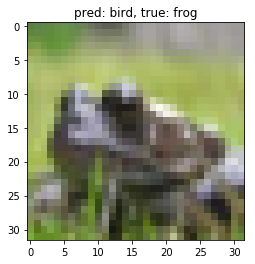

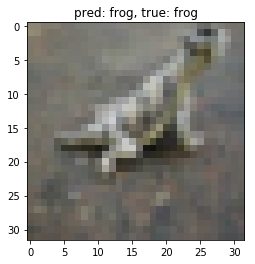

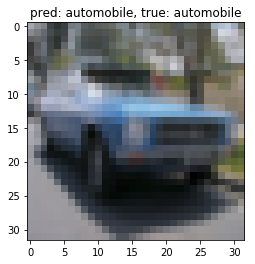

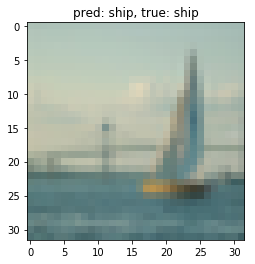

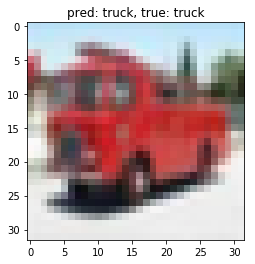

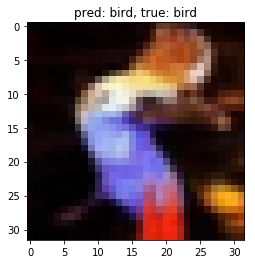

In [8]:
import visualizations
import numpy.random as nprand

visualizations.plot_learning_curve(losses)

indices = nprand.randint(10000, size=10)

sample_data = cifar_10.test.data[indices]
sample_labels = cifar_10.test.labels[indices]
y_pred = sess.run(y, feed_dict={x: sample_data, y_true: sample_labels, keep_prob:1})

visualizations.visualize_cifar_10(sample_data, y_pred, sample_labels)